In [67]:
import sys
sys.path.append('..')
sys.path.append('../beit2')
from datamodules import DATAMODULE_REGISTRY
from models import MODEL_REGISTRY
import torch
from pytorch_lightning import LightningModule
import torch.nn as nn
import opt_einsum
import einops
from modules.cmli import max_neg_value
from modules import mask_eos

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from transformers import BertTokenizer
import textwrap
import math

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


In [ ]:
MODEL_PATH = ""

In [3]:
coco_dm_kwargs = {
    'data_path': '../../data',
    'num_max_bpe_tokens': 64,
    'color_jitter': None,
    'beit_transforms': False,
    'crop_scale': [1.0, 1.0],
    'batch_size': 9,
    'num_workers': 1,
    'shuffle': True,
    'drop_last': False,
}

In [4]:
import pytorch_lightning as pl
pl.seed_everything(42)
coco_dm = DATAMODULE_REGISTRY['coco_captions'](**coco_dm_kwargs)

Seed set to 42


In [5]:
coco_dm.prepare_data()
coco_dm.setup('fit')

DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
INFO:datasets_.base_datasets:[COCOCaptions]: Data already exists under: ../../data/coco
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
INFO:datasets_.base_datasets:[COCOCaptions]: Data already exists under: ../../data/coco
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
INFO:datasets_.base_datasets:[COCOCaptions]: Data already exists under: ../../data/coco
INFO:datasets_.base_datasets:[COCOCaptions]: Load 566747 image-text pairs from ../../data/coco/coco_captioning.train.jsonl. 
INFO:datasets_.base_datasets:[COCOCaptions]: Load 25010 image-text pairs from ../../data/coco/coco_captioning.val.jsonl. 


In [16]:
dl = coco_dm.train_dataloader()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_cls:LightningModule = MODEL_REGISTRY['Sx3HRe']['module']
model = model_cls.load_from_checkpoint(MODEL_PATH).model
model = model.to(device)
model.requires_grad_(False)
model.eval()

In [18]:
def create_grid_overlay(ax, img_size=224, square_size=16):
    num_squares = img_size // square_size  # 14 for a 224x224 image with 16x16 squares
    for i in range(num_squares):
        for j in range(num_squares):
            # Draw rectangle (square)
            rect = plt.Rectangle((j*square_size, i*square_size), square_size, square_size,
                                 facecolor='none', edgecolor='black', linewidth=2)
            ax.add_patch(rect)

In [7]:
def add_token(ax, row, col, square_size, token):
    center_x = (col+0.5)*square_size 
    center_y = (row+0.5)*square_size
    ax.text(center_x, center_y, token, color='black', fontsize=8, ha='center', va='center')

In [46]:
def fit_text(figure, axes, text):
    bbox = axes.get_position()
    fig_width_inch = figure.get_size_inches()[0]
    axes_width_inch = bbox.width * fig_width_inch
    char_width_inch = 0.1
    max_chars_per_line = int(axes_width_inch / char_width_inch)
    wrapped_text = "\n".join(textwrap.wrap(text, width=max_chars_per_line))
    return wrapped_text

In [8]:
def plot(image, text, token2patch) -> None:
    default_w, default_h = plt.rcParams['figure.figsize']

    fig, ax = plt.subplots(1, 1, figsize=(default_w*2, default_h*2))
    
    ax.imshow(image.permute(1, 2, 0))

    grid_size = 14
    patch_size = 224 // grid_size

    create_grid_overlay(ax, img_size=224, square_size=patch_size)
    tokens = tokenizer.convert_ids_to_tokens(text)

    for idx, (row, col) in enumerate(token2patch.tolist()):
        add_token(ax, row, col, patch_size, tokens[idx])

    ax.set_title(tokenizer.decode(text), fontsize=16)

    ax.axis('off')
    fig.show()

In [9]:
def vis_t_clmi(model:nn.Module, text, padding_mask, image) -> None:
    text_emb = model.encode_text(text=text, padding_mask=padding_mask)['encoder_out'][1:]
    text_emb = text_emb / text_emb.norm(dim=1, keepdim=True)

    image_emb = model.encode_image(image=image)['encoder_out'][1:]
    image_emb = image_emb / image_emb.norm(dim=1, keepdim=True)

    sim = opt_einsum.contract('b t d, b i d -> b t i', text_emb, image_emb)

    padding_mask = mask_eos(padding_mask)[1:]

    token2patch_idx = sim.argmax(dim=-1)
    token2patch_idx_row = token2patch_idx // 14
    token2patch_idx_col = token2patch_idx % 14
    token2patch_coords = torch.stack([token2patch_idx_row, token2patch_idx_col], dim=-1)

    return token2patch_coords

In [ ]:
plot(image, raw_texts, token2patch_coords)

In [167]:
def plot_legend(ax, text_list, colors):
    # Define the maximum number of items per column
    max_items_per_column = 5
    step_size = 1 / max_items_per_column

    # Calculate the number of columns needed
    num_columns = math.ceil(len(text_list) / max_items_per_column)
    
    # Loop through each column
    for col in range(num_columns):
        # Determine the items for this column
        start_idx = col * max_items_per_column
        end_idx = start_idx + max_items_per_column
        column_texts = text_list[start_idx:end_idx]
        column_colors = colors[start_idx:end_idx]

        # Plot the squares and texts for this column
        for i, (color, text) in enumerate(zip(column_colors, column_texts)):
            y = (1-step_size/2)-step_size*i
            x = col*(1/num_columns)
            color[-1] = 0.5 # Set the alpha value to 0.5
            ax.add_patch(plt.Rectangle((x, y), 0.05, 0.05, color=color, ec='black'))
            ax.text(x + 0.08, y+0.025, text, fontsize=12, va='center', ha='left')

    ax.axis('off')

def plot_image(fig, ax, image, tokens, token2patch, colors) -> None:
    ax.imshow(image)

    patch_size = 16
    n_patches = 224 // patch_size

    ax.set_xticks(np.linspace(0, 224, n_patches + 1))
    ax.set_yticks(np.linspace(0, 224, n_patches + 1))
    #ax.grid(color='black', linestyle='-', linewidth=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_ylim(0, 224)
    ax.set_xlim(0, 224)

    for idx, areas in enumerate(token2patch.tolist()):
        for row, col in areas:
            x = col*patch_size 
            y = row*patch_size
            ax.add_patch(plt.Rectangle((x, y), patch_size, patch_size, color=colors[idx], alpha=0.5))
    
    ax.set_title(fit_text(fig, axes=ax, text=' '.join(tokens)), fontsize=12)

def plot(image, text, token2patch) -> None:
    default_w, default_h = plt.rcParams['figure.figsize']

    tokens = tokenizer.convert_ids_to_tokens(text)
    colors = cm.rainbow(np.linspace(0, 1, len(tokens)))

    fig = plt.figure(figsize=(default_w*2, default_h))
    gs = fig.add_gridspec(1, 2, wspace=0, hspace=0.3)
    ax = fig.add_subplot(gs[0, 0])
    plot_image(fig, ax, image, tokens, token2patch, colors)

    ax = fig.add_subplot(gs[0, 1])
    plot_legend(ax, tokens, colors)
    fig.show()


/var/folders/gt/cjpcl37j15s8yxsjswrtpxf40000gn/T/ipykernel_42589/4079566521.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


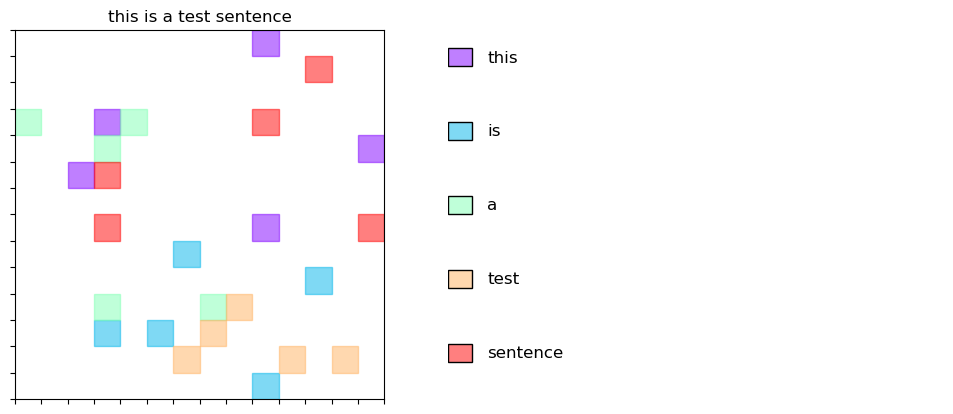

In [168]:
image_np = np.ones((224, 224, 3))
tokens = tokenizer.convert_tokens_to_ids(tokenizer.tokenize("This is a test sentence"))
token2patch = torch.randint(0, 14, (5, 5, 2))
plot(image_np, tokens, token2patch)